# Imports

In [23]:
!pwd
import sys
sys.path.append("..")
from bumps.names import Curve, fit, FitProblem
from bumps.dream.state import load_state
import matplotlib.pyplot as plt
import numpy as np
import scipy.fft as fft
import molgroups as mol
import os


/Users/frank/Box/DiffractionModeling/diffraction_fits/DOPC/JohnNagle_DOPC_Sim/Test/fit_accounting_for_missing_oxygen_in_model


# Variables

In [24]:
ed2sld = 2.814e-5
# bulk sld used during form factor calculation from experimental data
bulksld_ffc = 0.333 * ed2sld

maxarea = 100
stepsize = 0.1
#make sure dimension is odd
dimension = 1501
startz = 50

store = "T4"
setupdir = os.getcwd()
runfile = "run"
fitsource = "bumps"

if not os.path.isdir(store):
    os.mkdir(store)

run = False
burn = 10000
steps = 500

# Functions

In [25]:
def getSLD(aArea, aSL, normArea, bulksld):
    aSLD = np.zeros(dimension).tolist()
    
    # bulksld_ffc can be replaced by bulksld if it is assumed that during form factor calculation
    # the correct subtraction was applied
    
    for i in range(dimension):
        if aArea[i] != 0:
            aSLD[i] = aSL[i] / (aArea[i] * stepsize) * aArea[i] / normArea + bulksld_ffc * (1 - aArea[i] / normArea)
        else:
            aSLD[i] = bulksld_ffc
    return aSLD


In [26]:
def symmetrize(aSLD, bulksld):
    center = bilayer.fnGetCenter()
    center = int(center/stepsize+0.5)
    canvas_center = len(aSLD) // 2
    n = int(canvas_center - center)
    centered_bilayer = np.roll(aSLD, n)
    symmetrized_bilayer = np.add(centered_bilayer, centered_bilayer[::-1]) * 0.5
    symmetrized_bilayer -= bulksld
    return symmetrized_bilayer


In [27]:
def computeFormFactor(lq, aSLD, prefactor, dq, offset, stepsize, DCTtype=1):

    half_bilayer = aSLD[int(len(aSLD)/2) :]

    # TODO: Make sure that lq and x are roughly comparable
    # dimension should be odd
    dct_dimension = 5001
    
    # DCT is unnormalized, except for stepsize, which ensures that FO obeys the integral norm
    F = fft.dct(half_bilayer, n=dct_dimension, type=DCTtype) * stepsize
    F = np.abs(F)
    # normalization by integral of FF
    #sum = F.sum() * np.pi / (2 * dct_dimension * stepsize) * (2 * 1) * dq
    #if sum != 0:
    #    F /= sum
    x = np.array(
        [
            np.pi / (2 * dct_dimension * stepsize) * (2 * i) * dq
            for i in range(dct_dimension)
        ]
    )

    # interpolate (x, F) onto lq -> (lq, modelform)
    return np.interp(lq, x, F, period=None) * prefactor - offset


In [28]:
def setBilayer(
    l_lipid, va1, vm1, l_choline, v_choline, l_cg, v_cg, l_phosphate, v_phosphate, sigma, rel_pos, hg1_thickness, methyl_sigma, bulksld
):
    bilayer.volacyllipid=va1
    bilayer.volmethyllipid=vm1
    
    bilayer.headgroup1.choline.vol = bilayer.headgroup2.choline.vol = v_choline #108.6 # was 120
    bilayer.headgroup1.phosphate.vol = bilayer.headgroup2.phosphate.vol = v_phosphate #54
    bilayer.headgroup1.cg.vol = bilayer.headgroup2.cg.vol = v_cg # 156.2-15 # was 147

    choline_SL = 1.407e-3
    phosphate_SL = 1.323e-3
    cg_SL = 1.885e-3 - (8*0.00002814) # one O is missing
    
    bilayer.headgroup1.choline.l = bilayer.headgroup2.choline.l = l_choline
    bilayer.headgroup1.phosphate.l = bilayer.headgroup2.phosphate.l = l_phosphate
    bilayer.headgroup1.cg.l = bilayer.headgroup2.cg.l = l_cg

    bilayer.headgroup1.fnSet(hg1_thickness, rel_pos, cg_SL, choline_SL, phosphate_SL)
    bilayer.headgroup1.fnSetSigma(sigma)
    bilayer.headgroup2.fnSet(hg1_thickness, rel_pos, cg_SL, choline_SL, phosphate_SL)
    bilayer.headgroup2.fnSetSigma(sigma)

    bilayer.methyl_sigma = methyl_sigma
    bilayer.fnSet(sigma, bulksld, startz, l_lipid, l_lipid, vf_bilayer=1)


In [29]:
def modelformfactor(
    lq,
    l_lipid,
    va1,
    vm1,
    l_choline,
    v_choline,
    l_cg,
    v_cg,
    l_phosphate,
    v_phosphate,
    sigma,
#    prefactor,
#    dq,
#    offset,
    rel_pos,
    hg1_thickness,
    methyl_sigma,
    bulksld
):
    setBilayer(
        l_lipid,
        va1,
        vm1,
        l_choline,
        v_choline,
        l_cg,
        v_cg,
        l_phosphate,
        v_phosphate,
        sigma,
        rel_pos,
        hg1_thickness,
        methyl_sigma,
        bulksld
    )
    
    #set all unused parameters
    dq=1.0
    prefactor = 1.0
    offset=0.
    
    z = np.linspace(0, dimension * stepsize, dimension, endpoint=False)
    normArea, aArea, aSL = bilayer.fnWriteProfile(z)
    aSLD = getSLD(aArea, aSL, normArea, bulksld)
    aSLD = symmetrize(aSLD, bulksld)
    modelform = computeFormFactor(lq, aSLD/ed2sld, prefactor, dq, offset, stepsize)
    problem.extra = bilayer
    problem.stepsize = stepsize
    problem.dimension = dimension
    problem.sld = aSLD
    return modelform


# Fit Setup

In [30]:
#ULV = np.loadtxt("exp_data/dopcULV.dat")
#MLV = np.loadtxt("exp_data/dopcMLVs.dat")
#ORI = np.loadtxt("exp_data/dopcOri.dat")
#F2 = np.concatenate((ULV, MLV, ORI))
F2 = np.loadtxt("xff.dat")
F2 = F2[np.argsort(F2[:, 0])]
q_exp = F2[:, 0]
form_exp = F2[:, 1]
# constant error bar estimate of .05 Å
dform_exp = [0.01] * len(form_exp)


Set scattering lengths, volumes, lengths
| abb | name |
| :- | :- |
|va1 |Volume acyl chains, lipid 1|
|na1 |SL acyl chains, lipid 1|
|vm1 |Volume methyl groups, lipid 1|
|nm1 |SL methyl groups, lipid 1|
|vh1 |Headgroup volume, lipid 1|
|nh1 |SL headgroup, lipid 1|
|lh1 |Length headgroup, lipid 1|
|va2 |Volume acyl chains, lipid 2|
|na2 |SL acyl chains, lipid 2|
|vm2 |Volume methyl groups, lipid 2|
|nm2 |SL methyl groups, lipid 2|
|vh2 |Headgroup volume, lipid 2|
|nh2 |SL headgroup, lipid 2|
|lh2 |Length headgroup, lipid 2|
|va3 |Volume acyl chains, lipid 3|
|na3 |SL acyl chains, lipid 3|
|vm3 |Volume methyl groups, lipid 3|
|nm3 |SL methyl groups, lipid 3|
|vh3 |Headgroup volume, lipid 3|
|nh3 |SL headgroup, lipid 3|
|lh3 |Length headgroup, lipid 3|
|vc  |volume cholesterol|
|nc  |SL cholesterol|


In [31]:
bilayer = mol.BLM_quaternary()
na1, nh1, nm1, va1, vm1, vh1, lh1 = (
    7.5978e-03,
    4.6150e-03,
    5.0652e-04,
    985.60,
    100.4,
    318.80,
    9.56,
)
bilayer.fnInit(va1, na1, vm1, nm1, vh1, nh1, lh1)


In [32]:
l_lipid_initial = 11
va1_initial=985.6
vm1_initial=100.4
l_choline_initial = 6.34
v_choline_initial = 120
l_cg_initial = 4.21
v_cg_initial = 147
l_phosphate_initial = 3.86
v_phosphate_initial = 54
sigma_initial = 2.0
bulksld_initial = 9.4114e-06
prefactor_initial = 1
dq_initial = 1
offset_initial = 0
rel_pos_initial = 0.5
methyl_sigma_initial = 0.1


In [33]:
M2 = Curve(
    modelformfactor,
    q_exp,
    form_exp,
    dform_exp,
    l_lipid=l_lipid_initial,
    va1=va1_initial,
    vm1=vm1_initial,
    l_choline=l_choline_initial,
    v_choline=v_choline_initial,
    l_cg=l_cg_initial,
    v_cg=v_cg_initial,
    l_phosphate=l_phosphate_initial,
    v_phosphate=v_phosphate_initial,
    sigma=sigma_initial,
#    prefactor=prefactor_initial,
#    dq=dq_initial,
#    offset=offset_initial,
    rel_pos=rel_pos_initial,
    hg1_thickness=lh1,
    methyl_sigma=methyl_sigma_initial,
    bulksld=bulksld_initial
)


In [34]:
M2.l_lipid.range(9, 13)
M2.va1.range(950, 1005)
M2.vm1.range(90, 110)
M2.l_choline.range(2, 7.5)
M2.v_choline.range(100., 140.)
M2.l_cg.range(1, 7)
M2.v_cg.range(130., 170.)
M2.l_phosphate.range(0.1, 7)
M2.v_phosphate.range(40., 80.)
M2.sigma.range(1.0, 4.0)
#M2.prefactor.range(0.5, 1.5)
#M2.dq.range(0.95, 1.1)
#M2.offset.range(-0.1, 0.1)
M2.hg1_thickness.range(7, 12)
M2.rel_pos.range(0, 1)
M2.methyl_sigma.range(0, 3)
M2.bulksld.range(9.35e-6, 9.42e-6)


Parameter(bulksld)

# Run the fit

In [35]:
model = M2
problem = FitProblem(model)


In [36]:
from bumps.mapper import MPMapper

mapper = MPMapper.start_mapper(problem, None, cpus=0)  # cpus=0 for all CPUs
if run:
    result = fit(
        problem,
        method="dream",
        mapper=mapper,
        samples=10,
        burn=burn,
        steps=steps,
        thin=1,
        alpha=0,
        outliers="none",
        trim="none",
        verbose=True,
    )
    res_state = result.state
    res_state.save(store + "/" + runfile)  # save chains
    problem.fitness.save(store + "/" + runfile)  # save fit plot data

else:
    print(os.getcwd() + "/" + store + "/" + runfile)
    res_state = load_state(os.getcwd() + "/" + store + "/" + runfile)
    res_state.mark_outliers()


/Users/frank/Box/DiffractionModeling/diffraction_fits/DOPC/JohnNagle_DOPC_Sim/Test/fit_accounting_for_missing_oxygen_in_model/T4/run


# Analyze Fit

1.313313213528074


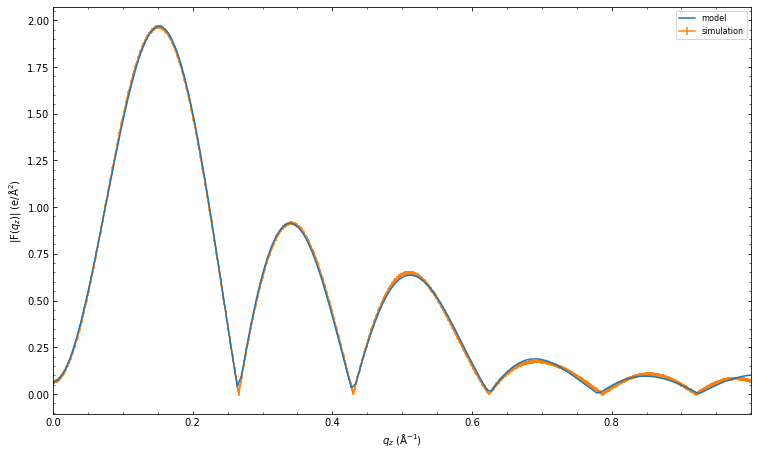

In [37]:
p = res_state.best()[0]
problem.setp(p)
print(problem.chisq())

q, F, dq, Fy = np.loadtxt(store + "/" + runfile + ".dat", skiprows=1).T
fig, ax = plt.subplots()
ax.plot(q, Fy, zorder=2, label="model")
ax.errorbar(q, F, dq, zorder=1, label="simulation")
ax.legend(fontsize=8)
ax.set_xlim([q[0], q[-1]])
ax.set_ylabel("|F($q_z$)| (e/Å$^2$)", fontsize=10)
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q_z$ (Å$^{-1}$)", fontsize=10)
ax.figure.set_size_inches(12.5, 7.5)
plt.savefig(store + "/model.png", facecolor="white")
plt.show()


In [38]:
from bumps.dream.stats import var_stats, save_vars

print("final chisq", problem.chisq_str())
draw = res_state.draw(portion=1)
all_vstats = var_stats(draw)
save_vars(all_vstats, store + "/" + runfile + ".json")


final chisq 1.313(16)


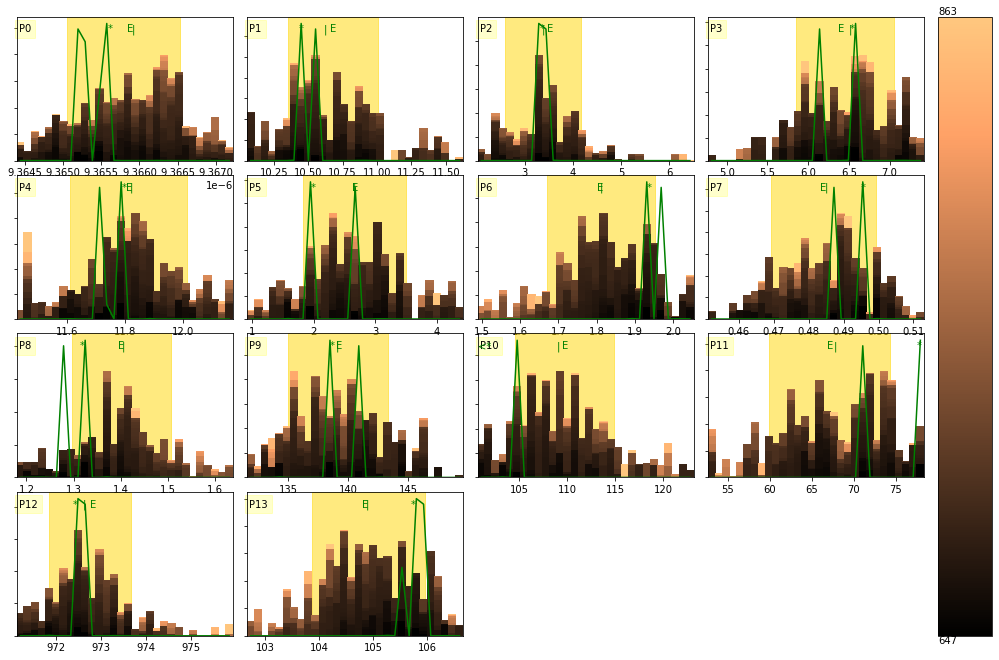

In [39]:
from bumps.dream import corrplot, varplot
from pylab import figure, savefig

err = sys.stderr
sys.stderr = open("/dev/stderr", "w")
figure(figsize=varplot.var_plot_size(len(all_vstats)))
nbins = max(min(draw.points.shape[0] // 10000, 400), 30)
varplot.plot_vars(draw, all_vstats, nbins=nbins)
if run:
    savefig(store + "/var", facecolor="white")
else:
    savefig(store + "/var_reloaded", facecolor="white")
sys.stderr = err


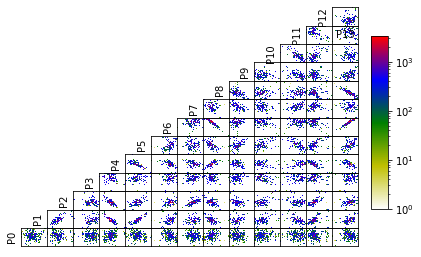

In [40]:
if draw.num_vars <= 25:
    figure()
    c = corrplot.Corr2d(draw.points.T, bins=nbins, labels=draw.labels)
    c.plot()
if run:
    savefig(store + "/corr", facecolor="white")
else:
    savefig(store + "/corr_reloaded", facecolor="white")


In [41]:
p = res_state.best()[0]
problem.setp(p)
print(problem.chisq())


1.313313213528074


In [42]:
sys.path.append(os.pardir + "/PlottingAndAnalysis")
import rs
import os


if run:
    if os.path.isfile(store + "/sErr.dat"):
        os.remove(store + "/sErr.dat")
    if os.path.isfile(store + "/isErr.dat"):
        os.remove(store + "/isErr.dat")
    if os.path.isfile(store + "/StatDataPython.dat"):
        os.remove(store + "/StatDataPython.dat")

fit_analysis = rs.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=res_state,
    problem=problem,
)


In [43]:
sparse = 0.01
fit_analysis.fnAnalyzeStatFile(fConfidence=-1, sparse=sparse)


Found sErr.dat

Analysis of current MC simulation ...
Number of iterations: 549
      bulksld  [  +        ]  [  9.35e-06,  9.42e-06]  [ 9.365e-06(0.000),  9.366e-06(0.000),  9.367e-06(0.000)] (- 8.163e-10, + 6.785e-10)
hg1_thickness  [       +|  ]  [         7,        12]  [     10.39(0.000),      10.62(0.000),         11(0.000)] (-     0.233, +     0.384)
         l_cg  [   |-|     ]  [         1,         7]  [     2.642(0.000),      3.385(0.000),      4.223(0.000)] (-    0.7431, +    0.8377)
    l_choline  [       |-| ]  [         2,       7.5]  [     5.892(0.000),      6.524(0.001),      7.055(0.000)] (-    0.6312, +    0.5312)
      l_lipid  [       +   ]  [         9,        13]  [     11.61(0.000),      11.82(0.000),         12(0.000)] (-    0.2093, +    0.1744)
  l_phosphate  [   |-|     ]  [       0.1,         7]  [     1.876(0.003),      2.691(0.000),      3.496(0.000)] (-     0.815, +    0.8052)
 methyl_sigma  [      +|   ]  [         0,         3]  [      1.68(0.001),      

In [44]:
fit_analysis.fnCreateBilayerPlotData()

Initializing ...
Pulling all molgroups ...
  substrate ...
Failure to load StatDataPython.dat.
Recreate statistical data from sErr.dat.
Found sErr.dat

Processing parameter set 0.

1.3932781752062793
Processing parameter set 1.

1.6949659880209518
Processing parameter set 2.

1.349796308035969
Processing parameter set 3.

1.44676718389251
Processing parameter set 4.

1.371393016358063
Processing parameter set 5.

1.9642964273114942
Processing parameter set 6.

1.6949659880209518
Processing parameter set 7.

1.44676718389251
Processing parameter set 8.

1.3711677866551821
Processing parameter set 9.

1.6118421901991482
Processing parameter set 10.

1.8912236091989658
Processing parameter set 11.

1.382862341060169
Processing parameter set 12.

1.4493173293718888
Processing parameter set 13.

1.346083405785769
Processing parameter set 14.

1.376532223144427
Processing parameter set 15.

1.4591088798521321
Processing parameter set 16.

1.4050155574006644
Processing parameter set 17.

1.45

1.314722524760355
Processing parameter set 165.

1.3881655935423132
Processing parameter set 166.

1.365795612021232
Processing parameter set 167.

1.5848446252312385
Processing parameter set 168.

1.4022397482386488
Processing parameter set 169.

1.693001516691868
Processing parameter set 170.

1.4410926786209985
Processing parameter set 171.

1.396962409926396
Processing parameter set 172.

1.4221178075075578
Processing parameter set 173.

1.4043861130265023
Processing parameter set 174.

1.420010828475543
Processing parameter set 175.

1.4332522328720907
Processing parameter set 176.

1.396962409926396
Processing parameter set 177.

1.4191067177463341
Processing parameter set 178.

1.5136817945607877
Processing parameter set 179.

1.411739411370465
Processing parameter set 180.

1.4131233892601756
Processing parameter set 181.

1.3771654560880673
Processing parameter set 182.

1.4225489524360728
Processing parameter set 183.

1.3629283288033158
Processing parameter set 184.

1.38338

1.5241819121670395
Processing parameter set 330.

1.4425387126448919
Processing parameter set 331.

1.3749781918932549
Processing parameter set 332.

1.3544032914806243
Processing parameter set 333.

1.3982508725308818
Processing parameter set 334.

1.4776775114644485
Processing parameter set 335.

1.4503969925652247
Processing parameter set 336.

1.3749781918932549
Processing parameter set 337.

1.414857698195609
Processing parameter set 338.

1.6338834184370694
Processing parameter set 339.

1.4185160152589826
Processing parameter set 340.

1.4802400814893193
Processing parameter set 341.

1.432076107839209
Processing parameter set 342.

1.585389045646119
Processing parameter set 343.

1.3683235952954658
Processing parameter set 344.

1.3495821226903804
Processing parameter set 345.

1.3415041844985391
Processing parameter set 346.

1.4421507490606411
Processing parameter set 347.

1.3293082551929933
Processing parameter set 348.

1.3266947773767046
Processing parameter set 349.

1.3

1.3352668560864844
Processing parameter set 495.

1.353824227616364
Processing parameter set 496.

1.3821929488623699
Processing parameter set 497.

1.3483439674314892
Processing parameter set 498.

1.4420995823020313
Processing parameter set 499.

1.3483439674314892
Processing parameter set 500.

1.3609805116639722
Processing parameter set 501.

1.3771502269783484
Processing parameter set 502.

1.389263443214237
Processing parameter set 503.

1.438266374480893
Processing parameter set 504.

1.4289072444259134
Processing parameter set 505.

1.3953312997100007
Processing parameter set 506.

1.378301664435522
Processing parameter set 507.

1.4801209859457654
Processing parameter set 508.

1.3253784911384865
Processing parameter set 509.

1.7129903227898073
Processing parameter set 510.

1.4247292158926084
Processing parameter set 511.

1.3649590928780782
Processing parameter set 512.

1.3780933956852752
Processing parameter set 513.

1.3992355679138964
Processing parameter set 514.

1.36

In [45]:
fit_analysis.fnCalculateMolgroupProperty(fConfidence=-1)


Loaded statistical data from StatDataPython.dat
Did not find any fractional envelopes ...
WaterFracHeadgroup1  [    0.5727,     0.5871,     0.6043] (-   0.01435, +   0.01723)
WaterFracHeadgroup2  [    0.5658,     0.5809,     0.5994] (-    0.0151, +   0.01847)
WaterFracHydrocarbon  [   0.01188,    0.01844,    0.02365] (-  0.006562, +  0.005214)
WaterFracLipid1  [    0.0125,    0.01936,    0.02473] (-  0.006862, +  0.005373)
WaterFracLipid2  [   0.01125,    0.01763,    0.02268] (-  0.006384, +  0.005049)
WaterFracSubMembrane  [    0.9971,     0.9976,     0.9979] (- 0.0004731, + 0.0003341)
bilayer_defect_hc_AVG  [         0,          0,          0] (-         0, +         0)
bilayer_defect_hc_COM  [     1e+05,      1e+05,      1e+05] (-         0, +         0)
bilayer_defect_hc_INT  [         0,          0,          0] (-         0, +         0)
bilayer_defect_hg_AVG  [         0,          0,          0] (-         0, +         0)
bilayer_defect_hg_COM  [     1e+05,      1e+05,      1e+05

In [46]:
# Carry over manually!
areaperlipid = 73.41
areaperlipid_sim = 72.4
bulknsld_fit=9.366e-06
prefactor_fit=1
offset_fit=0
v_cg_fit = 139
v_phosphate_fit = 67.27
v_choline_fit = 109
va1_fit = 972.6
vm1_fit = 104.9
dq_fit=1.0

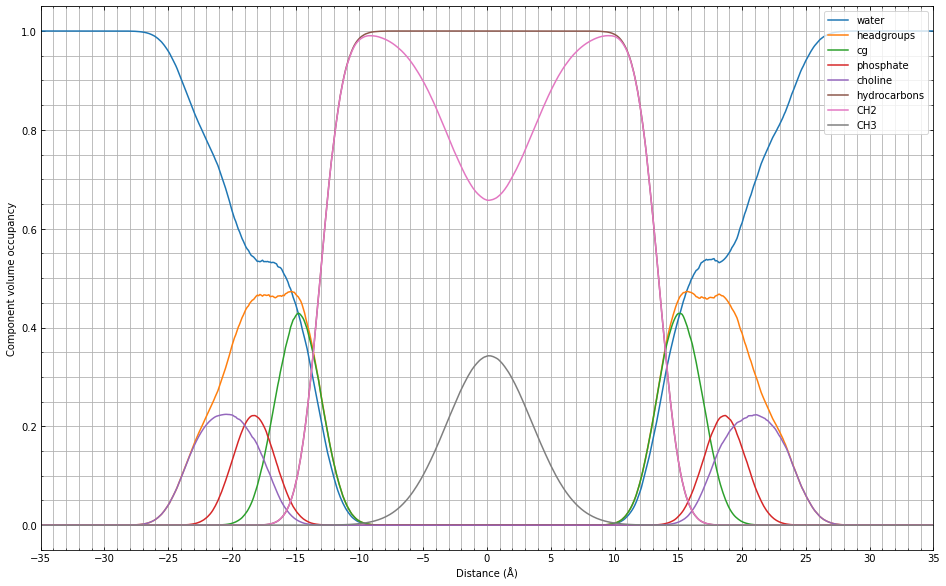

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import sys

bilayer_plot_data = pd.read_csv(
    store + "/bilayerplotdata.dat", sep="\s", engine="python"
)

zax = bilayer_plot_data["zaxis"] - 0.5 * bilayer_plot_data["zaxis"][len(bilayer_plot_data["zaxis"])-1]+1.3

fig, ax = plt.subplots()
ax.plot(zax, bilayer_plot_data["water_corr_cvo"], label="water")
ax.plot(zax, bilayer_plot_data["innerhg_corr_cvo"] + bilayer_plot_data["outerhg_corr_cvo"], label="headgroups")
ax.plot(zax, bilayer_plot_data["inner_cg_corr_cvo"] + bilayer_plot_data["outer_cg_corr_cvo"],label="cg")
ax.plot(zax, bilayer_plot_data["inner_phosphate_corr_cvo"] + bilayer_plot_data["outer_phosphate_corr_cvo"], label="phosphate")
ax.plot(zax, bilayer_plot_data["inner_choline_corr_cvo"] + bilayer_plot_data["outer_choline_corr_cvo"], label="choline")
ax.plot(zax, bilayer_plot_data["innerhc_corr_cvo"]+bilayer_plot_data["outerhc_corr_cvo"], label="hydrocarbons")
ax.plot(zax, bilayer_plot_data["innerch2_corr_cvo"]+bilayer_plot_data["outerch2_corr_cvo"], label="CH2")
ax.plot(zax, bilayer_plot_data["innerch3_corr_cvo"]+bilayer_plot_data["outerch3_corr_cvo"], label="CH3")
ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("Component volume occupancy")
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
plt.xlim(-35, 35)
plt.xticks(np.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
ax.figure.set_size_inches(16, 10)
plt.savefig(store + "/cvo", facecolor="white")
plt.show()

# Diagnostics

Simulation number density times electron number:
choline:  49.98850759999983
phosphate:  46.98311119999985
cg:  58.9887687999998
hc:  269.94463079999906
methyl:  17.99429599999994
water:  309.490234799999


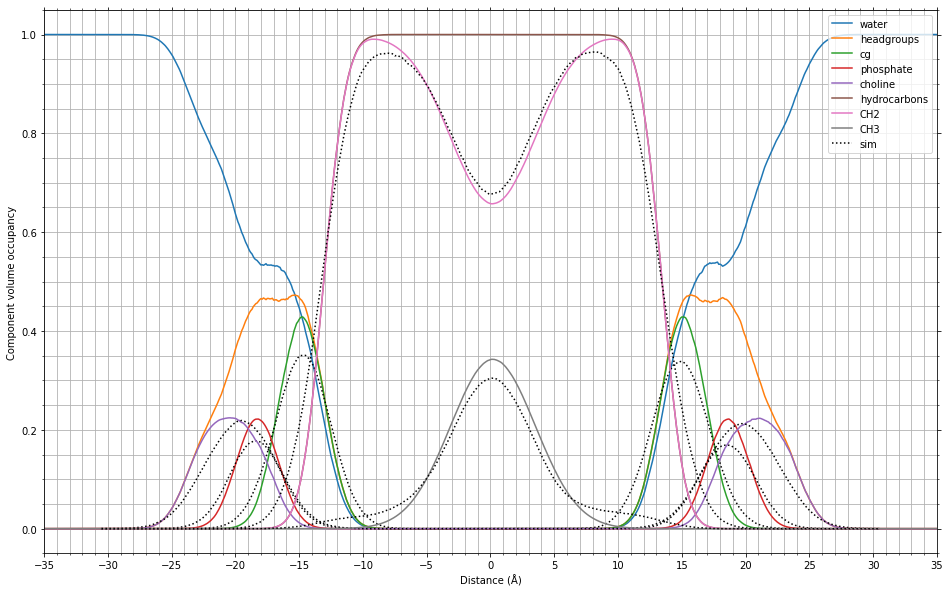

Fit:
choline:  108.36311868143491
phosphate:  67.14061284437298
cg:  138.4355904994758
hc:  973.7812021689712
methyl:  104.83900687780006
Simulation, volume weighted electron densities:
choline:  108.97494656799961
phosphate:  67.24582745582956
cg:  138.97354005423682
hc:  972.395748458568
methyl:  104.86675835555519


In [48]:
# Create an electron density profile from the sim data and, in a second step
# divide it by the electron densities per molecular group used in the fit
# this creates a volume-correct plot of the electron densities.



simdata = pd.read_csv('../../dopc72.4bcut.sim', sep="\s+", comment='#')
#print(simdata)

columnlist = list(simdata)
for element in columnlist:
    if element[0] == 'o':
        simdata[element]=simdata[element].multiply(8.)
    if element[0] == 'h':
        simdata[element]=simdata[element].multiply(1.)
    if element[0] == 'd':
        simdata[element]=simdata[element].multiply(1.)
    if element[0] == 'n':
        simdata[element]=simdata[element].multiply(7.)
    if element[0] == 'p':
        simdata[element]=simdata[element].multiply(15.)
    if element[0] == 'c':
        simdata[element]=simdata[element].multiply(6.)


ph_str = "ph op1h op2h op3h op4h"
ph_col = ph_str.split()
cg_str = "c1c1 o1c1 c1h h1ah h1bh c1c2 o1c2 o2h c2h h2ah c3h h3ah h3bh" #o1h missing
cg_col = cg_str.split()
chol_str = "c6h h6ah h6bh h6ch c7h h7ah h7bh h7ch c8h h8ah h8bh h8ch c4h h4ah h4bh c5h h5ah h5bh nh"
chol_col = chol_str.split()
ch2_str = "c2c1 h2ac1 h2bc1 c3c1 h3ac1 h3bc1 c4c1 h4ac1 h4bc1 c5c1 h5ac1 h5bc1 c6c1 h6ac1 h6bc1 c7c1 h7ac1 h7bc1 c8c1 h8ac1 h8bc1 c11c1 h11ac1 h11bc1 c12c1 h12ac1 h12bc1 c13c1 h13ac1 h13bc1 c14c1 h14ac1 h14bc1 c15c1 h15ac1 h15bc1 c16c1 h16ac1 h16bc1 c17c1 h17ac1 h17bc1 c2c2 h2ac2 h2bc2 c3c2 h3ac2 h3bc2 c4c2 h4ac2 h4bc2 c5c2 h5ac2 h5bc2 c6c2 h6ac2 h6bc2 c7c2 h7ac2 h7bc2 c8c2 h8ac2 h8bc2 c11c2 h11ac2 h11bc2 c12c2 h12ac2 h12bc2 c13c2 h13ac2 h13bc2 c14c2 h14ac2 h14bc2 c15c2 h15ac2 h15bc2 c16c2 h16ac2 h16bc2 c17c2 h17ac2 h17bc2 c9c1 c10c1 h9ac1 h10ac1 c9c2 c10c2 h9ac2 h10ac2"
ch2_col = ch2_str.split()
ch3_str = "c18c1 h18ac1 h18bc1 h18cc1 c18c2 h18ac2 h18bc2 h18cc2"
ch3_col = ch3_str.split()
h2o_str = "ow d1w d2w"
h2o_col = h2o_str.split()

ph_sim=simdata[ph_col].sum(axis=1).to_numpy()
cg_sim=simdata[cg_col].sum(axis=1).to_numpy()
chol_sim=simdata[chol_col].sum(axis=1).to_numpy()
ch2_sim=simdata[ch2_col].sum(axis=1).to_numpy()
ch3_sim=simdata[ch3_col].sum(axis=1).to_numpy()
h2o_sim=simdata[h2o_col].sum(axis=1).to_numpy()
z_sim = simdata["Zbin"].to_numpy()

stepsize_sim = z_sim[1]-z_sim[0]
print("Simulation number density times electron number:")
print("choline: ",chol_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("phosphate: ",ph_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("cg: ",cg_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("hc: ",(ch2_sim+ch3_sim).sum()*stepsize_sim*areaperlipid_sim/2)
print("methyl: ",ch3_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("water: ",h2o_sim.sum()*stepsize_sim*areaperlipid_sim/2)

# edensity 
ed_total = (ph_sim+cg_sim+chol_sim+ch2_sim+ch3_sim+h2o_sim)
ed_mf = ph_sim+cg_sim+chol_sim+ch2_sim+ch3_sim

normfactor=1.0
ph_sim*=normfactor/(47/v_phosphate_fit)
cg_sim*=normfactor/((67-8)/(v_cg_fit))      #should be (67, 147), but one O is missing
chol_sim*=normfactor/(50/v_choline_fit)
ch2_sim*=normfactor/(252/(va1_fit-vm1_fit))
ch3_sim*=normfactor/(18/vm1_fit)

fig, ax = plt.subplots()
ax.plot(zax, bilayer_plot_data["water_corr_cvo"], label="water")
ax.plot(zax, bilayer_plot_data["innerhg_corr_cvo"] + bilayer_plot_data["outerhg_corr_cvo"], label="headgroups")

ax.plot(zax, bilayer_plot_data["inner_cg_corr_cvo"] + bilayer_plot_data["outer_cg_corr_cvo"],label="cg")
ax.plot(z_sim, cg_sim, linestyle='dotted', color='black')

ax.plot(zax, bilayer_plot_data["inner_phosphate_corr_cvo"] + bilayer_plot_data["outer_phosphate_corr_cvo"], label="phosphate")
ax.plot(z_sim, ph_sim, linestyle='dotted', color='black')

ax.plot(zax, bilayer_plot_data["inner_choline_corr_cvo"] + bilayer_plot_data["outer_choline_corr_cvo"], label="choline")
ax.plot(z_sim, chol_sim, linestyle='dotted', color='black')

ax.plot(zax, bilayer_plot_data["innerhc_corr_cvo"]+bilayer_plot_data["outerhc_corr_cvo"], label="hydrocarbons")

ax.plot(zax, bilayer_plot_data["innerch2_corr_cvo"]+bilayer_plot_data["outerch2_corr_cvo"], label="CH2")
ax.plot(z_sim, ch2_sim, linestyle='dotted', color='black')

ax.plot(zax, bilayer_plot_data["innerch3_corr_cvo"]+bilayer_plot_data["outerch3_corr_cvo"], label="CH3")
ax.plot(z_sim, ch3_sim, linestyle='dotted', color='black', label="sim")

ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("Component volume occupancy")
ax.minorticks_on()
#ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
plt.xlim(-35, 35)
plt.xticks(np.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
ax.figure.set_size_inches(16, 10)
plt.savefig(store + "/cvo_sldweighted", facecolor="white")
plt.show()

stepsize_z=zax[1]-zax[0]
print("Fit:")
print("choline: ",bilayer_plot_data["inner_choline_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("phosphate: ",bilayer_plot_data["inner_phosphate_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("cg: ",bilayer_plot_data["inner_cg_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("hc: ",bilayer_plot_data["innerhc_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("methyl: ",bilayer_plot_data["innerch3_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("Simulation, volume weighted electron densities:")
print("choline: ",chol_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("phosphate: ",ph_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("cg: ",cg_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("hc: ",(ch2_sim+ch3_sim).sum()*stepsize_sim*areaperlipid_sim/2)
print("methyl: ",ch3_sim.sum()*stepsize_sim*areaperlipid_sim/2)


Number of electrons (half bilayer):
choline:  18.99623959999993
phosphate:  4.998278799999984
cg:  12.997320399999955
hc:  99.97947679999966
methyl:  7.998389999999973


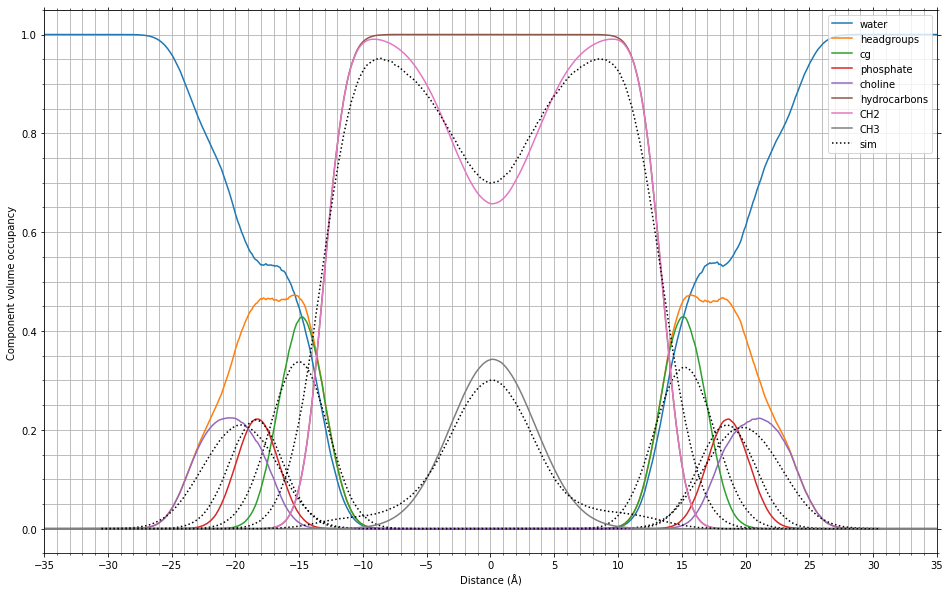

Fit:
choline:  108.36311868143491
phosphate:  67.14061284437298
cg:  138.4355904994758
hc:  973.7812021689712
methyl:  104.83900687780006
Simulation, volume weighted electron densities:
choline:  108.97842717894699
phosphate:  84.0585537189997
cg:  138.97134889230722
hc:  972.4005086180401
methyl:  104.87888887499963


In [49]:
# Create an volume density plot using VDW radii

simdata = pd.read_csv('../../dopc72.4bcut.sim', sep="\s+", comment='#')
#print(simdata)

columnlist = list(simdata)
#for element in columnlist:
#    if element[0] == 'o':
#        simdata[element]=simdata[element].multiply(0.5*4./3.*np.pi*(1.6)**3)
#    if element[0] == 'h':
#        simdata[element]=simdata[element].multiply(0.5*4./3.*np.pi*(1.2)**3)
#    if element[0] == 'n':
#        simdata[element]=simdata[element].multiply(0.5*4./3.*np.pi*(1.7)**3)
#    if element[0] == 'p':
#        simdata[element]=simdata[element].multiply(0.5*4./3.*np.pi*(1.8)**3)
#    if element[0] == 'c':
#        simdata[element]=simdata[element].multiply(0.5*4./3.*np.pi*(1.9)**3)


ph_str = "ph op1h op2h op3h op4h"
ph_col = ph_str.split()
cg_str = "c1c1 o1c1 c1h h1ah h1bh c1c2 o1c2 o2h c2h h2ah c3h h3ah h3bh" #o1h missing
cg_col = cg_str.split()
chol_str = "c6h h6ah h6bh h6ch c7h h7ah h7bh h7ch c8h h8ah h8bh h8ch c4h h4ah h4bh c5h h5ah h5bh nh"
chol_col = chol_str.split()
ch2_str = "c2c1 h2ac1 h2bc1 c3c1 h3ac1 h3bc1 c4c1 h4ac1 h4bc1 c5c1 h5ac1 h5bc1 c6c1 h6ac1 h6bc1 c7c1 h7ac1 h7bc1 c8c1 h8ac1 h8bc1 c11c1 h11ac1 h11bc1 c12c1 h12ac1 h12bc1 c13c1 h13ac1 h13bc1 c14c1 h14ac1 h14bc1 c15c1 h15ac1 h15bc1 c16c1 h16ac1 h16bc1 c17c1 h17ac1 h17bc1 c2c2 h2ac2 h2bc2 c3c2 h3ac2 h3bc2 c4c2 h4ac2 h4bc2 c5c2 h5ac2 h5bc2 c6c2 h6ac2 h6bc2 c7c2 h7ac2 h7bc2 c8c2 h8ac2 h8bc2 c11c2 h11ac2 h11bc2 c12c2 h12ac2 h12bc2 c13c2 h13ac2 h13bc2 c14c2 h14ac2 h14bc2 c15c2 h15ac2 h15bc2 c16c2 h16ac2 h16bc2 c17c2 h17ac2 h17bc2 c9c1 c10c1 h9ac1 h10ac1 c9c2 c10c2 h9ac2 h10ac2"
ch2_col = ch2_str.split()
ch3_str = "c18c1 h18ac1 h18bc1 h18cc1 c18c2 h18ac2 h18bc2 h18cc2"
ch3_col = ch3_str.split()

ph_sim=simdata[ph_col].sum(axis=1).to_numpy()
cg_sim=simdata[cg_col].sum(axis=1).to_numpy()
chol_sim=simdata[chol_col].sum(axis=1).to_numpy()
ch2_sim=simdata[ch2_col].sum(axis=1).to_numpy()
ch3_sim=simdata[ch3_col].sum(axis=1).to_numpy()
z_sim = simdata["Zbin"].to_numpy()

stepsize_sim = z_sim[1]-z_sim[0]
print("Number of electrons (half bilayer):")
print("choline: ",chol_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("phosphate: ",ph_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("cg: ",cg_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("hc: ",(ch2_sim+ch3_sim).sum()*stepsize_sim*areaperlipid_sim/2)
print("methyl: ",ch3_sim.sum()*stepsize_sim*areaperlipid_sim/2)

normfactor=1.0
ph_sim*=normfactor/4*(v_phosphate_fit)
cg_sim*=normfactor/(14-1)*(v_cg_fit)   #should be (14,147), but one O is missing      
chol_sim*=normfactor/19*(v_choline_fit)
ch2_sim*=normfactor/92*(va1_fit-vm1_fit)
ch3_sim*=normfactor/8*vm1_fit

fig, ax = plt.subplots()
ax.plot(zax, bilayer_plot_data["water_corr_cvo"], label="water")
ax.plot(zax, bilayer_plot_data["innerhg_corr_cvo"] + bilayer_plot_data["outerhg_corr_cvo"], label="headgroups")

ax.plot(zax, bilayer_plot_data["inner_cg_corr_cvo"] + bilayer_plot_data["outer_cg_corr_cvo"],label="cg")
ax.plot(z_sim, cg_sim, linestyle='dotted', color='black')

ax.plot(zax, bilayer_plot_data["inner_phosphate_corr_cvo"] + bilayer_plot_data["outer_phosphate_corr_cvo"], label="phosphate")
ax.plot(z_sim, ph_sim, linestyle='dotted', color='black')

ax.plot(zax, bilayer_plot_data["inner_choline_corr_cvo"] + bilayer_plot_data["outer_choline_corr_cvo"], label="choline")
ax.plot(z_sim, chol_sim, linestyle='dotted', color='black')

ax.plot(zax, bilayer_plot_data["innerhc_corr_cvo"]+bilayer_plot_data["outerhc_corr_cvo"], label="hydrocarbons")

ax.plot(zax, bilayer_plot_data["innerch2_corr_cvo"]+bilayer_plot_data["outerch2_corr_cvo"], label="CH2")
ax.plot(z_sim, ch2_sim, linestyle='dotted', color='black')

ax.plot(zax, bilayer_plot_data["innerch3_corr_cvo"]+bilayer_plot_data["outerch3_corr_cvo"], label="CH3")
ax.plot(z_sim, ch3_sim, linestyle='dotted', color='black', label='sim')

ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("Component volume occupancy")
ax.minorticks_on()
#ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
plt.xlim(-35, 35)
plt.xticks(np.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
ax.figure.set_size_inches(16, 10)
plt.savefig(store + "/cvo_atomdensityweighted", facecolor="white")
plt.show()

print("Fit:")
print("choline: ",bilayer_plot_data["inner_choline_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("phosphate: ",bilayer_plot_data["inner_phosphate_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("cg: ",bilayer_plot_data["inner_cg_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("hc: ",bilayer_plot_data["innerhc_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("methyl: ",bilayer_plot_data["innerch3_corr_cvo"].sum()*stepsize_z*areaperlipid)
print("Simulation, volume weighted electron densities:")
print("choline: ",chol_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("phosphate: ",ph_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("cg: ",cg_sim.sum()*stepsize_sim*areaperlipid_sim/2)
print("hc: ",(ch2_sim+ch3_sim).sum()*stepsize_sim*areaperlipid_sim/2)
print("methyl: ",ch3_sim.sum()*stepsize_sim*areaperlipid_sim/2)


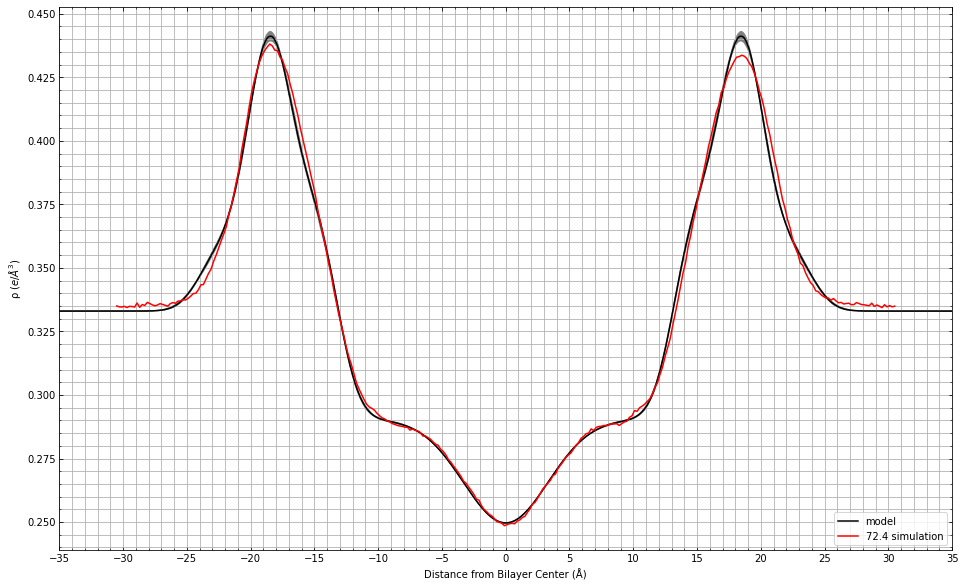

In [50]:
#feller = np.loadtxt("FellerDOPCSimedp.dat")


a = fit_analysis.diStatResults["nSLDProfiles"]
b = []
for i in range(len(a)):
    it = a[i][0][0]
    it = [(it[n] + bulknsld_fit) / 2.814e-5 for n in range(len(it))]
    b += [it]

b = np.array(b).T
c = []
for i in range(len(b)):
    cc = fit_analysis.fnCalcConfidenceLimits(b[i])
    c += [cc]
c = np.array(c).T
z = [stepsize * (i - np.argmin(c[2])) for i in range(dimension)]

plt.figure(figsize=(16, 10))
plt.fill_between(z, c[3], y2=c[1], color="grey")
plt.xlabel("Distance from Bilayer Center (Å)")
plt.ylabel("ρ $(e/Å^3)$")
plt.plot(z, c[2], color="black", label="model")
#plt.plot(feller[:, 0], feller[:, 1], color="red", label="feller")
plt.plot(z_sim, ed_total, color="red", label="72.4 simulation")
plt.minorticks_on()
plt.tick_params(which="both", direction="in", labelsize=10)
plt.tick_params(bottom=True, top=True, left=True, right=True, which="both")
plt.legend(loc="lower right")
plt.xlim(-35, 35)
plt.xticks(np.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
plt.savefig(store + "/electron_density", facecolor="white")
plt.show()


## Solvent-subtracted electron density profile

Stepsizes:
fit:  0.09999999999999432 0.09999999999999432
SDP:  0.1999999999999993 0.1999999999999993
Integral (half): 
fit:  -0.03556302560331436
SDP:  -0.10139399999999837
FO from DCT-definition (half profile):
fit:  0.06280756003460565
SDP:  0.20278799999999675
F0 estimate (half profile):
fit:  0.07112605120662872
SDP:  0.20278799999999675


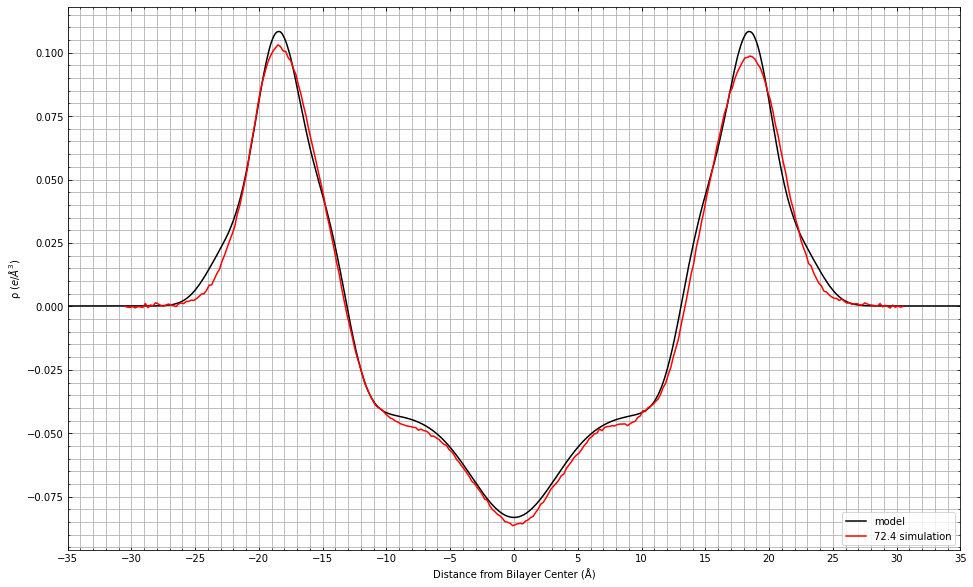

In [51]:
fit_ed_minus_fluid = c[2]-bulknsld_fit/ed2sld
sdp_ed_minus_fluid = ed_total-9.4269e-6/ed2sld

sum_fit = fit_ed_minus_fluid.sum()
sum_sdp = sdp_ed_minus_fluid.sum()
half_fit_ed_minus_fluid = fit_ed_minus_fluid[int(len(fit_ed_minus_fluid)/2) :]
half_sdp_ed_minus_fluid = sdp_ed_minus_fluid[int(len(sdp_ed_minus_fluid)/2) :]
half_sum_fit = half_fit_ed_minus_fluid.sum()
half_sum_sdp = half_sdp_ed_minus_fluid.sum()

print("Stepsizes:")
print("fit: ", stepsize_z, z[1] - z[0])
print("SDP: ", stepsize_sim, z_sim[1] - z_sim[0])

print("Integral (half): ")
print("fit: ", half_sum_fit * stepsize_z)
print("SDP: ", half_sum_sdp * stepsize_sim)
#print("SDP_mf", half_sum_spd_mf * stepsize_sim)

print("FO from DCT-definition (half profile):")
print("fit: ", np.abs((2 * half_sum_fit - half_fit_ed_minus_fluid[0])* stepsize_z))
print("SDP: ", np.abs((2 * half_sum_sdp) * stepsize_sim))

print("F0 estimate (half profile):")
print("fit: ", np.abs(half_sum_fit * stepsize_z)*2)
print("SDP: ", np.abs(half_sum_sdp * stepsize_sim)*2)

plt.figure(figsize=(16, 10))
plt.xlabel("Distance from Bilayer Center (Å)")
plt.ylabel("ρ $(e/Å^3)$")
plt.plot(z, fit_ed_minus_fluid, color="black", label="model")
#plt.plot(z[int(len(z)/2):], half_fit_ed_minus_fluid+0.02, color="black", label="1/2 model + 0.02")
#plt.plot(feller[:, 0], feller[:, 1], color="red", label="feller")
plt.plot(z_sim, sdp_ed_minus_fluid, color="red", label="72.4 simulation")
#plt.plot(z_sim, ed_mf, label="72.4 simulation mf")
#plt.plot(z_sim[int(len(z_sim)/2):], half_sdp_ed_minus_fluid+0.02, color="red", label="1/2 72.4 simulation + 0.02")
plt.minorticks_on()
plt.tick_params(which="both", direction="in", labelsize=10)
plt.tick_params(bottom=True, top=True, left=True, right=True, which="both")
plt.legend(loc="lower right")
plt.xlim(-35, 35)
plt.xticks(np.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
plt.savefig(store + "/electron_density_fluid_subtracted", facecolor="white")
plt.show()


In [52]:
Afterfit_FF = computeFormFactor(q, fit_ed_minus_fluid, prefactor_fit, dq_fit, 0, z[1] - z[0])
SDP_FF = computeFormFactor(q, sdp_ed_minus_fluid, 1, dq_fit, 0, z_sim[1] - z_sim[0], DCTtype=2)

1.313313213528074


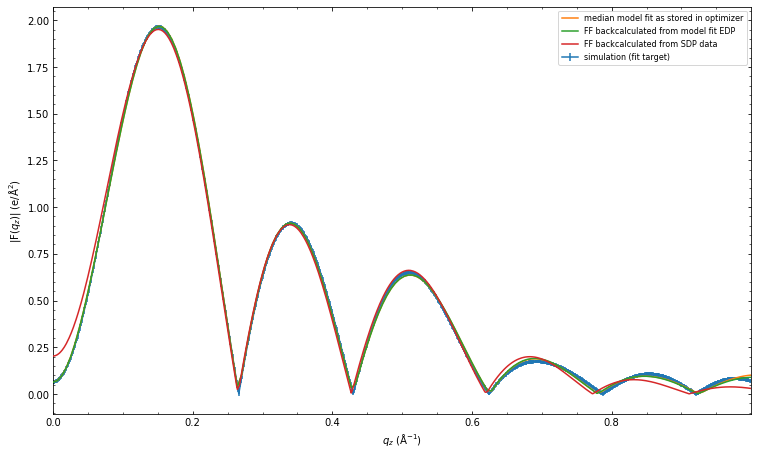

In [53]:
p = res_state.best()[0]
problem.setp(p)
print(problem.chisq())

q, F, dq, Fy = np.loadtxt(store + "/" + runfile + ".dat", skiprows=1).T
fig, ax = plt.subplots()
ax.errorbar(q, F, dq, zorder=1, label="simulation (fit target)")
ax.plot(q, Fy, zorder=2, label="median model fit as stored in optimizer")
ax.plot(q, Afterfit_FF, zorder=3, label="FF backcalculated from model fit EDP")
ax.plot(q, SDP_FF, zorder=4, label="FF backcalculated from SDP data")

ax.legend(fontsize=8)
ax.set_xlim([q[0], q[-1]])
ax.set_ylabel("|F($q_z$)| (e/Å$^2$)", fontsize=10)
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q_z$ (Å$^{-1}$)", fontsize=10)
ax.figure.set_size_inches(12.5, 7.5)
plt.savefig(store + "/model_comparison.png", facecolor="white")
plt.show()


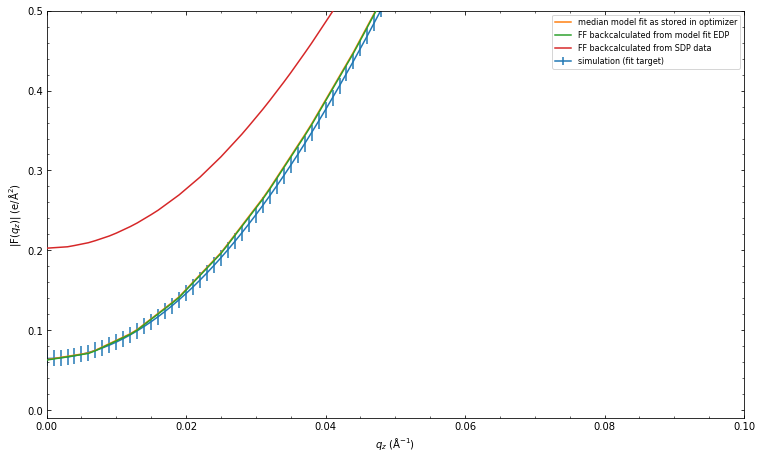

In [54]:
fig, ax = plt.subplots()
ax.errorbar(q, F, dq, zorder=1, label="simulation (fit target)")
ax.plot(q, Fy, zorder=2, label="median model fit as stored in optimizer")
ax.plot(q, Afterfit_FF, zorder=3, label="FF backcalculated from model fit EDP")
ax.plot(q, SDP_FF, zorder=4, label="FF backcalculated from SDP data")

ax.legend(fontsize=8)
ax.set_xlim([q[0], q[-1]])
ax.set_ylabel("|F($q_z$)| (e/Å$^2$)", fontsize=10)
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
ax.set_xlabel("$q_z$ (Å$^{-1}$)", fontsize=10)
ax.figure.set_size_inches(12.5, 7.5)
plt.xlim(0.0, 0.1)
plt.ylim(-0.01, 0.5)
plt.savefig(store + "/model_comparison_zoom.png", facecolor="white")
plt.show()